In [1]:
import pandas, numpy, string, textblob
import pickle
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import xgboost
from keras import layers, models, optimizers
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt

# DATASET 

In [2]:
#Load training data
df_train = pandas.read_excel('E:/Natural Language Processing/Project/ML/dataset/train_data.xlsx')
#Load testing data
df_test = pandas.read_excel('E:/Natural Language Processing/Project/ML/dataset/test_data.xlsx')

In [3]:
# Display the column names of the DataFrame
print(df_train.columns)

# Display the structure of the DataFrame
print(df_train.head())

df_train.info()


Index(['doc_text', 'class'], dtype='object')
                                            doc_text       class
0  In article <1993Apr9.172945.4578@island.COM> g...     medical
1  In article <1993Apr5.184527.1@aurora.alaska.ed...       space
2  Sounds liek what the FED has to do is sign a 5...       space
3  Lib Dems' new election PR chief\n\nThe Lib Dem...    politics
4  Gallipoli Campaign\nWith World War I having ef...  historical
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doc_text  800 non-null    object
 1   class     800 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


In [4]:
df_train.head()
df_train.info()
df_count = df_train.groupby(['class'], as_index = False).agg({'doc_text': 'count'})
df_count.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doc_text  800 non-null    object
 1   class     800 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


,class,doc_text
0,business,76
1,entertainment,83
2,food,80
3,graphics,82
4,historical,78
5,medical,78
6,politics,84
7,space,73
8,sport,77
9,technologies,89


# TEXT PREPROCESSING 

1. Tokenization – It is about splitting strings of text into smaller pieces, or “tokens”. Paragraphs can be tokenized into sentences and sentences can be tokenized into words.
2. Noise Removal – I have further cleaned up the text in this step. I have achieved so by removing punctuations, stop words, extra whitespaces and many other data points which was irrelevant to the NLP tasks. The NLTK library has inbuild functionalities for many such operations. A brief description of few of the steps taken is as:
    1. Removed HTML tags: Since articles scrapped from web are likely to contain HTML tags, therefore have used Python package BeautifulSoup to remove HTML tags.
    2. Remove stop words, accented characters and punctuation: As stop words, punctuations, extra whitespaces and accented characters do not add useful information to our text processing algorithm, therefore have removed them using modules such as Unicode and spaCy.
    3. Treating Numbers: In our application numbers do not provide any significant knowledge and so, we have removed them. Firstly, in order to standardize the text, have converted number words to numeric form and then removed them from the textual data.
3. Normalization – In this process, I have standardized the text into uniform sequence. I have converted the text to lowercase and using NLTK libraries performed stemming and lemmatization. Stemming refers to removing the suffixes attached to a word and lemmatization refers to conserving the root word of a word. We have used lemmatization for our textual data because that performed better with the pre-trained word embedding

In [5]:
!pip install beautifulsoup4 nltk unidecode

import re, unidecode
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

# Needed only once
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text
def remove_numbers(text): 
    result = re.sub(r'\d+', '', text) 
    return result
def remove_slash_with_space(text): 
    return text.replace('\\', " ")
def remove_punctuation(text): 
    translator = str.maketrans('', '', string.punctuation) 
    return text.translate(translator) 
def text_lowercase(text): 
    return text.lower()     
def remove_whitespace(text): 
    return  " ".join(text.split()) 
def remove_stopwords(text): 
    stop_words = set(stopwords.words("english")) 
    word_tokens = word_tokenize(text) 
    filtered_text = [word for word in word_tokens if word not in stop_words] 
    return ' '.join(filtered_text)
def stem_words(text): 
    stemmer = PorterStemmer() 
    word_tokens = word_tokenize(text) 
    stems = [stemmer.stem(word) for word in word_tokens] 
    return ' '.join(stems)
def lemmatize_words(text): 
    lemmatizer = WordNetLemmatizer() 
    word_tokens = word_tokenize(text) 
    # provide context i.e. part-of-speech 
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
    return ' '.join(lemmas) 

DEPRECATION: Loading egg at c:\users\user\appdata\local\programs\python\python311\lib\site-packages\aniso8601-9.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\user\appdata\local\programs\python\python311\lib\site-packages\distlib-0.3.8-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\user\appdata\local\programs\python\python311\lib\site-packages\dnspython-2.6.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\user\app

In [6]:
# Perform preprocessing
def perform_preprocessing(text):
    text = remove_html_tags(text)
    text = remove_accented_chars(text)
    text = remove_numbers(text)
    text = remove_stopwords(text)
    text = text_lowercase(text)
    text = remove_slash_with_space(text)
    text = remove_punctuation(text)
    # text = stem_words(text)
    text = lemmatize_words(text)
    text = remove_whitespace(text)
    return text

df_train['class'] = df_train['class'].apply(perform_preprocessing)
df_train['doc_text'] = df_train['doc_text'].apply(perform_preprocessing)
df_test['class'] = df_test['class'].apply(perform_preprocessing)
df_test['doc_text'] = df_test['doc_text'].apply(perform_preprocessing)

C:\Users\user\AppData\Local\Temp\ipykernel_27180\1658587471.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


# TRAIN TEST SPLIT 

In [7]:
X_train = df_train['doc_text']
X_test = df_test['doc_text']
y_train = df_train['class']
y_test = df_test['class']

# Feature Engineering 
Text files are actually series of words (ordered). In order to run machine learning algorithms we need to convert the text files into numerical feature vectors.

We will implement the following different ideas in order to obtain relevant features from our dataset.

1. CountVectors – I have used scikit-learn library’s CountVectorizer module to vectorize sentences. It generates vocabulary for all unique words of sentence. From this count of words, a feature vector is created. This essentially is the Bag of Words BOW model.

In [8]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train)
X_train_count =  count_vect.transform(X_train)
X_test_count =  count_vect.transform(X_test)

2. TF-IDF Vectors Word level - Now in order to assign weightage to the above feature vector, we have used Term Frequency – Inverse Document Frequency logic. We have given a score to the words based on its Term Frequency (#words/ #Total words) and its Inverse Frequency, i.e. presence in each of the documents. It low scores repetitive words.

In [9]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X_train)
X_train_tfidf =  tfidf_vect.transform(X_train)
X_test_tfidf =  tfidf_vect.transform(X_test)

3. TF-IDF Vectors N-Gram level – In this approach for better results, have combined N (>= 2) words to form N-grams. Bigrams (N=2) are the most optimal and best convey most important information among other N-grams.

In [10]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2), max_features=5000)
tfidf_vect_ngram.fit(X_train)
X_train_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

4. TF-IDF Vectors Character level- character level

In [11]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(X_train)
X_train_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train) 
X_test_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test) 

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:555: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


This code segment performs label encoding and binary encoding on the target variable, which is typically done when dealing with categorical variables, such as class labels in classification tasks. 

In [12]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

encoder = preprocessing.LabelBinarizer()
encoder.fit(y_train)
y_train_bi = encoder.transform(y_train)
y_test_bi = encoder.transform(y_test)

# MODEL SELECTION AND TRAINING

Classical models (Used as a Baseline Model)

This code defines a function named train_model which is used to train a classifier model on a given training dataset, make predictions on a validation dataset, and return the accuracy score of the predictions.

In [13]:
def train_model(classifier, X_train, y_train, X_test, y_test, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(X_train, y_train)
    # predict the labels on validation dataset
    predictions = classifier.predict(X_test)
    return metrics.accuracy_score(predictions, y_test)

Naïve Bayes Classifier – This classification technique is based on Bayes’ Theorem and assumes independence among the predictors

NB, Count Vectors:  0.94
NB, WordLevel TF-IDF:  0.965
NB, N-Gram Vectors:  0.955
NB, CharLevel Vectors:  0.7


<BarContainer object of 4 artists>

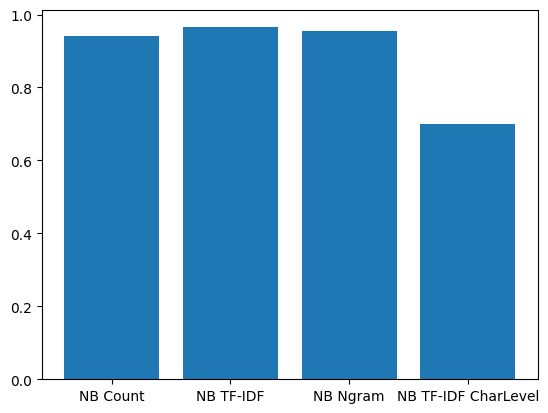

In [14]:
# Naive Bayes on Count Vectors
accuracy1 = train_model(naive_bayes.MultinomialNB(), X_train_count, y_train, X_test_count, y_test)
print("NB, Count Vectors: ", accuracy1)

# Naive Bayes on Word Level TF IDF Vectors
accuracy2 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("NB, WordLevel TF-IDF: ", accuracy2)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, y_test)
print("NB, N-Gram Vectors: ", accuracy3)

# Naive Bayes on Character Level TF IDF Vectors
accuracy4 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, y_test)
print("NB, CharLevel Vectors: ", accuracy4)

df = {'ModelType': ['NB Count', 'NB TF-IDF','NB Ngram', 'NB TF-IDF CharLevel' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

Logistic Regression – Logistic Regression is a statistical method used for binary classification tasks, where the target variable (dependent variable) has two possible outcomes. The main function of Logistic Regression is to model the probability that a given input belongs to a particular class.

LR, Count Vectors:  0.945
LR, WordLevel TF-IDF:  0.96
LR, N-Gram Vectors:  0.965
LR, CharLevel Vectors:  0.93


<BarContainer object of 4 artists>

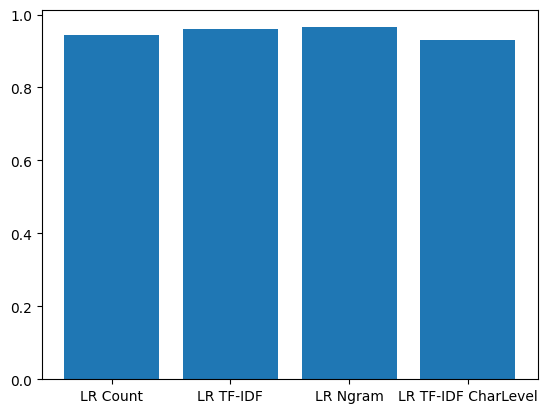

In [15]:
# Logistic Regression on Count Vectors
accuracy1 = train_model(linear_model.LogisticRegression(), X_train_count, y_train, X_test_count, y_test)
print("LR, Count Vectors: ", accuracy1)

# Logistic Regression on Word Level TF IDF Vectors
accuracy2 = train_model(linear_model.LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR, WordLevel TF-IDF: ", accuracy2)

# Logistic Regression on Ngram Level TF IDF Vectors
accuracy3 = train_model(linear_model.LogisticRegression(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, y_test)
print("LR, N-Gram Vectors: ", accuracy3)

# Logistic Regression on Character Level TF IDF Vectors
accuracy4 = train_model(linear_model.LogisticRegression(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, y_test)
print("LR, CharLevel Vectors: ", accuracy4)

df = {'ModelType': ['LR Count', 'LR TF-IDF','LR Ngram', 'LR TF-IDF CharLevel' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

Bagging Model (Random Forest) - Random Forest models are an ensemble learning technique that combines multiple decision trees during training. The main aim of these models is to reduce the overfitting. They work towards reducing the model complexity.

the accuracy of the model is calculated by comparing the predicted labels with the true labels.

RF, Count Vectors:  0.94
RF, WordLevel TF-IDF:  0.935


<BarContainer object of 4 artists>

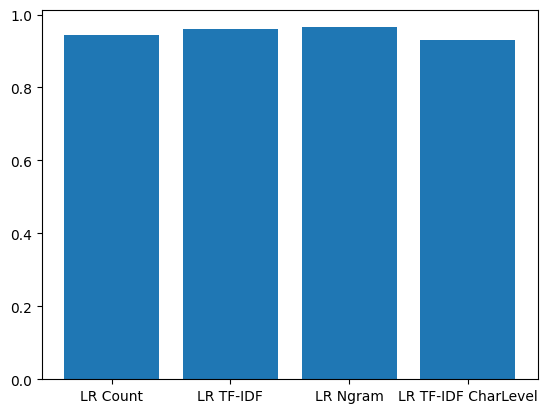

In [16]:
# RF on Count Vectors
accuracy1 = train_model(ensemble.RandomForestClassifier(), X_train_count, y_train, X_test_count, y_test)
print("RF, Count Vectors: ", accuracy1)

# RF on Word Level TF IDF Vectors
accuracy2 = train_model(ensemble.RandomForestClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("RF, WordLevel TF-IDF: ", accuracy2)

plt.bar(df['ModelType'], df['Accuracy'])

XG Boost - Boosting models are type of ensemble models and work to improve the model prediction rates. This model is meta-algorithm for reducing bias and variance in supervised learning. One of its strong points is that it converts weak learner i.e. classifiers slightly correlated to the true classification into stronger ones.

Xgb, Count Vectors:  0.86
Xgb, WordLevel TF-IDF:  0.93


<BarContainer object of 4 artists>

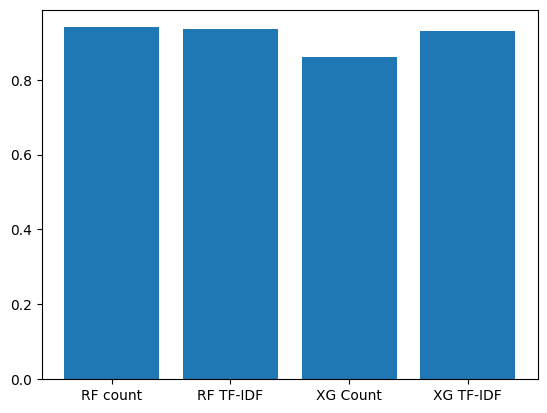

In [17]:
# Extereme Gradient Boosting (XG boost) on Count Vectors
accuracy3 = train_model(xgboost.XGBClassifier(), X_train_count.tocsc(), y_train, X_test_count.tocsc(), y_test)
print("Xgb, Count Vectors: ", accuracy3)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accurac4 = train_model(xgboost.XGBClassifier(), X_train_tfidf.tocsc(), y_train, X_test_tfidf.tocsc(), y_test)
print("Xgb, WordLevel TF-IDF: ", accuracy4)

# # Extereme Gradient Boosting on Character Level TF IDF Vectors
# accuracy = train_model(xgboost.XGBClassifier(), X_train_tfidf_ngram_chars.tocsc(), y_train, X_test_tfidf_ngram_chars.tocsc(), y_test)
# print("Xgb, CharLevel Vectors: ", accuracy)
df = {'ModelType': ['RF count', 'RF TF-IDF','XG Count', 'XG TF-IDF' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

# Shallow Neural Network

In order to improve the performance of the model, we used this CNN. Neural networks or feedforward neural networks. These have multiple layers of neurons arranged in fashion similar to that of human brain. The input feature vector is processed at each layer and then forwarded to the next hidden layer. The output for the next layer is created by multiplying the input with weight w and bias b. All of this summed up and then passed on to the activation function. I have rectified linear unit (ReLU) function. The algorithm initializes the weights and trains them using backpropagation. We reduced the error of the predicted output, it uses optimization methods like the gradient descent.

PARAMETERS

In order to have minimum training loss and maximize the accuracy, I have specified epochs of 100. Also, I have setup the batch size as 100. This essentially means that I have used 100 samples in one forward and backward pass to optimize the computation rate and memory consumption. Validation split of 10 % is used, this is a split of training data to calculate loss function and should be kept apart from testing set in order to not let testing set to influence the model.

In [19]:
plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               2560512   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 2,565,642
Trainable params: 2,565,642
Non-trainable params: 0
_________________________________________________________________


<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.ndarray'>
5000
Epoch 1/100
8/8 [==============================] - 2s 121ms/step - loss: 2.2352 - accuracy: 0.6069 - val_loss: 2.0873 - val_accuracy: 0.9375
Epoch 2/100
8/8 [==============================] - 1s 83ms/step - loss: 1.8887 - accuracy: 0.9931 - val_loss: 1.7305 - val_accuracy: 0.9750
Epoch 3/100
8/8 [==============================] - 1s 68ms/step - loss: 1.4417 - accuracy: 0.9958 - val_loss: 1.3340 - val_accuracy: 0.9875
Epoch 4/100
8/8 [==============================] - 1s 70ms/step - loss: 0.9878 - accuracy: 0.9986 - val_loss: 0.9547 - val_accuracy: 0.9875
Epoch 5/100
8/8 [==============================] - 1s 69ms/step - loss: 0.6082 - accuracy: 1.0000 - val_loss: 0.6627 - val_accuracy: 0.9875
Epoch 6/100
8/8 [==============================] - 1s 71ms/step - loss: 0.3540 - accuracy: 1.0000 - val_loss: 0.4777 - val_accuracy: 0.9750
Epoch 7/100
8/8 [==============================] - 1s 66ms/step - loss: 0.2065 - accuracy: 

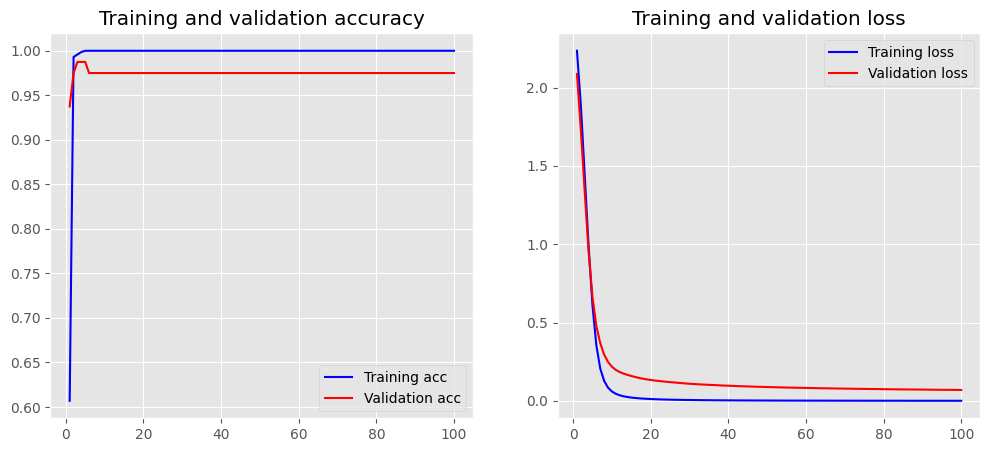

In [20]:
vocab_size = X_train_tfidf.shape[1]
num_labels = 4
batch_size = 100
# Neural network on TFIDF
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(vocab_size,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(10))
model.add(layers.Activation('softmax'))
model.summary()
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
print(type(X_train_tfidf))

print(type(y_train_bi))

print(vocab_size)

history = model.fit(X_train_tfidf.toarray(), y_train_bi,
                    batch_size=batch_size,
                    epochs=100,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_tfidf.toarray(), y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_tfidf.toarray(), y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

In [21]:
vocab_size = 15000
num_labels = 4
batch_size = 100
maxlen = 200

print(X_train)

from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence

tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding again 1 because of reserved 0 index

X_train_token = sequence.pad_sequences(X_train_token, padding='post', maxlen=maxlen)
X_test_token = sequence.pad_sequences(X_test_token, padding='post', maxlen=maxlen)
embedding_dim = 300


0      in article apr islandcom green islandcom rober...
1      in article apr auroraalaskaedu nsmca auroraala...
2      sound liek feed sign year lease use certain pa...
3      lib dems new election pr chief the lib dems ap...
4      gallipoli campaign with world war i effectivel...
                             ...                        
795    mp attack muggers kenya an mp ps passport stea...
796    european medal chance improve what european in...
797    radcliffe yet answer gb call paula radcliffe g...
798    abbas will tolerate attack palestinian leader ...
799    iaaf await greek pair s response kostas kenter...
Name: doc_text, Length: 800, dtype: object


# Another Feature Engineering

1. Word Embeddings (It has been found to work well with neural networks)

In this I have sought to represent words in the form of vectors. It preserves contextually similar words and reduces the high dimensional word features to low dimensional feature vectors. Deep learning model namely RNN and CNN use it in their algorithm. I have used GIoVe to create word embedding of a text. The module of Word2Vec has a preprocessing module, a continuous bag of words and skip-grams. The latter two features are essentially shallow neural networks.

Using Pretrained Word Embeddings

used Glove since it is faster, although less accurate than Word2Vec. GloVe uses co-occurrence matrix and matrix factorization to acheive dimensionality reduction

In [22]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    embedding_matrix = numpy.zeros((vocab_size, embedding_dim))

    with open(filepath,'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = numpy.array(
                    vector, dtype=numpy.float32)[:embedding_dim]

    return embedding_matrix

#basic new word embed
embedding_matrix = create_embedding_matrix('E:/Natural Language Processing/Project/ML/dataset/glove.6B/glove.6B.300d.txt',tokenizer.word_index, embedding_dim)
nonzero_elements = numpy.count_nonzero(numpy.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)

0.8442976156276932


In [23]:
# Shallow neural network basic with word embedding matrix
embedding_dim = 300

model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(512, input_shape=(vocab_size,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(10))
model.add(layers.Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(X_train_token, y_train_bi,
                    batch_size=batch_size,
                    epochs=100,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_token, y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_token, y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          6265800   
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 


 dense_2 (Dense)             (None, 512)               154112    
                                                                 
 activation_2 (Activation)   (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
 activation_3 (Activation)   (None, 10)                0         
                                                                 
Total params: 6,425,042
Trainable params: 6,425,042
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 4s 250ms/step - loss: 2.4347 - accuracy: 0.1208 - val_loss: 2.1270 - val_accuracy: 0.3500
Epoch 2/100
8/8 [==============================] - 1s 149ms/step - loss: 2.1788 - accuracy: 0.2944 - val_loss: 2.3576 - val_accuracy: 0.1000
Epoch 3/100
8/8 [==============================]

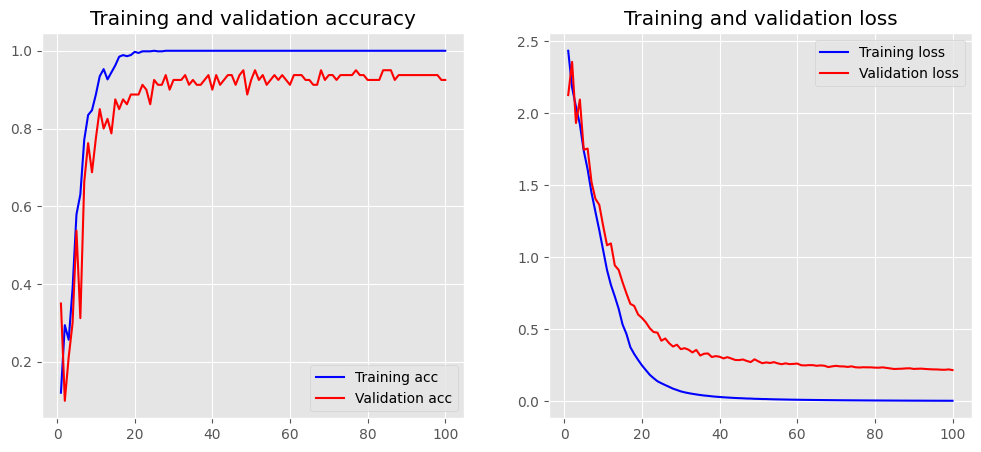

In [24]:
plot_history(history)

# Deep Neural Network

Using tensorflow 2.12 and Keras 2.12.  The embedding layer takes the precalculated integers, uses the embedding matrix of the pretrained vectors to assigns the dense vectors. This result is fed into flatten layer for sequential input. From there it is fed to dense layer. I have also used GlobalMaxPooling ID after the embedding. Thisreduces the sample size by choosing maximum value of all the features.

CNN (CovNets)

It is a specialized deep neural network to identify peculiar trends which is used to discern the most important information in a sentence. The hidden layers called convolutional layer starts with a sample of input features of the dimensions of kernel filters.  It has two uses – it provides fixed-length output and reduces output dimensionality of most important features. Such layers are stacked multiple times to improve mining of abstract information.

In [25]:
# Deep Neural networks CNN
model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10))
model.add(layers.Activation('softmax'))
model.summary()
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(X_train_token, y_train_bi,
                    batch_size=30,
                    epochs=100,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_token, y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_token, y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 300)          6265800   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 300)         0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          192128    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 activation_4 (Activation)   (None, 256)              

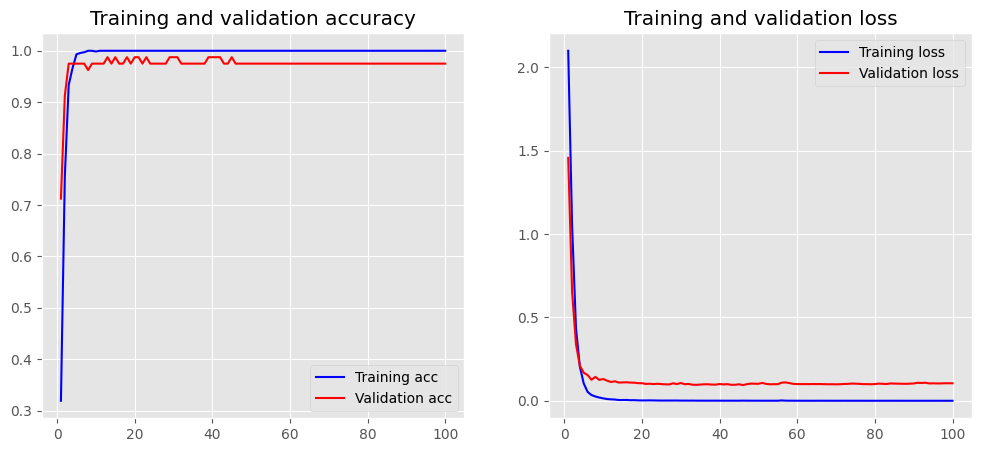

In [26]:
plot_history(history)

SAVE MODEL

In [58]:
# creates a HDF5 file 'my_model.h5'
model.save('E:/Natural Language Processing/Project/ML//dataset/NLP_model.h5')

# Save Tokenizer
with open('E:/Natural Language Processing/Project/ML//dataset/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

OPTIONAL

Recurrent Neural Network Bidirectional GRU

In RNN the activation outputs are propagated in both directions. It results in looping which provides a state to neurons giving it ability to remember the learnings. This memory is what gives the power to RNN but also impose the problem of Vanishing Gradient. The problem is slow learning rate and parameter tuning due to learning with large no. of layers. To solve this LSTMs (Long short term memory) is used but it often complex and slow computationally. A newer technique GRU is used in this paper. GRU exposes complete memory and has only 2 gates instead of 3 in case of LSTM. It provides similar performance as LSTM while faster to train.

In [27]:
# Bi directional rnn gru

model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.Bidirectional(layers.GRU(100)))
model.add(layers.Dense(512, input_shape=(vocab_size,)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10))
model.add(layers.Activation('softmax'))
# model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train_token, y_train_bi,
                    batch_size=batch_size,
                    epochs=100,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_token, y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_token, y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/100
8/8 [==============================] - 30s 3s/step - loss: 2.2276 - accuracy: 0.1903 - val_loss: 1.9669 - val_accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 20s 3s/step - loss: 1.8834 - accuracy: 0.5069 - val_loss: 1.6341 - val_accuracy: 0.6375
Epoch 3/100
8/8 [==============================] - 23s 3s/step - loss: 1.5173 - accuracy: 0.5847 - val_loss: 1.3026 - val_accuracy: 0.6625
Epoch 4/100
8/8 [==============================] - 22s 3s/step - loss: 1.1378 - accuracy: 0.6736 - val_loss: 0.9671 - val_accuracy: 0.7000
Epoch 5/100
8/8 [==============================] - 23s 3s/step - loss: 0.8103 - accuracy: 0.7375 - val_loss: 0.7688 - val_accuracy: 0.7250
Epoch 6/100
8/8 [==============================] - 24s 3s/step - loss: 0.5756 - accuracy: 0.8361 - val_loss: 0.6198 - val_accuracy: 0.7375
Epoch 7/100
8/8 [==============================] - 25s 3s/step - loss: 0.3821 - accuracy: 0.8722 - val_loss: 0.5430 - val_accuracy: 0.8125
Epoch 8/100
8/8 [==========

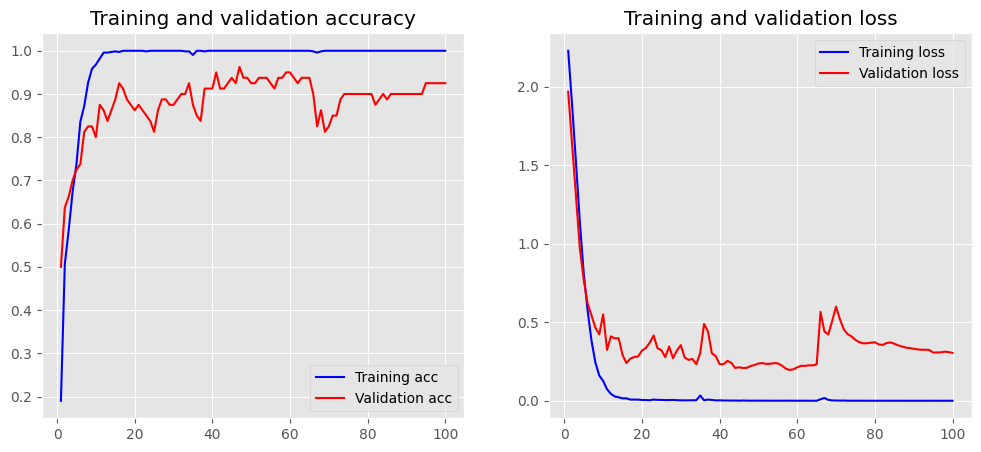

In [29]:
plot_history(history)

# RESULT AND TESTING

The model that gave the best performance on the test data is was CNN with an accuracy of 99.75 % with 100 epochs. The model can be used to process any document and predict a class for it. 

In [60]:
final_model = models.load_model('E:/Natural Language Processing/Project/ML/dataset/NLP_model.h5')
 
# load tokenizer
tokenizer = text.Tokenizer()
with open('E:/Natural Language Processing/Project/ML/dataset/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [61]:
df_count.head(10)

,class,doc_text
0,business,76
1,entertainment,83
2,food,80
3,graphics,82
4,historical,78
5,medical,78
6,politics,84
7,space,73
8,sport,77
9,technologies,89


In [62]:
class_dict = {'0': 'business', '1': 'entertainment','2': 'food','3': 'graphics', '4': 'historical', '5': 'medical', '6': 'politics', '7': 'space', '8': 'sport', '9':'technologies'}
inp = ["QR codes at San Antonio bus stops change the game for visually impaired commuters. Bus stops across San Antonio are getting easily detectible QR codes to help visually impaired commuters better navigate the city."]
inp = [perform_preprocessing(x) for x in inp]
inp_token = tokenizer.texts_to_sequences(inp)
inp_token = sequence.pad_sequences(inp_token, padding='post', maxlen=maxlen)

out = final_model.predict(inp_token)
predicted_label = numpy.argmax(out) 
print("Predicted label: " + class_dict.get(str(predicted_label)))

1/1 [==============================] - 0s 120ms/step
Predicted label: technologies


In [63]:
class_dict = {'0': 'business', '1': 'entertainment','2': 'food','3': 'graphics', '4': 'historical', '5': 'medical', '6': 'politics', '7': 'space', '8': 'sport', '9':'technologies'}
inp = ["A new California restaurant claims to be the first fully autonomous restaurant, with its burgers and fries made by robots. As fast food chains increasingly try to find ways for machines to replace some human workers, NBC News’ Elwyn Lopez gets an inside look."]
inp = [perform_preprocessing(x) for x in inp]
inp_token = tokenizer.texts_to_sequences(inp)
inp_token = sequence.pad_sequences(inp_token, padding='post', maxlen=maxlen)

out = final_model.predict(inp_token)
predicted_label = numpy.argmax(out) 
print("Predicted label: " + class_dict.get(str(predicted_label)))

1/1 [==============================] - 0s 29ms/step
Predicted label: food


In [ ]:
class_dict = {'0': 'business', '1': 'entertainment','2': 'food','3': 'graphics', '4': 'historical', '5': 'medical', '6': 'politics', '7': 'space', '8': 'sport', '9':'technologies'}
inp = ["7% is not an adequate growth rate… India ought to be growing more rapidly because of the demographic dividend: Jayanth R Varma"]
inp = [perform_preprocessing(x) for x in inp]
inp_token = tokenizer.texts_to_sequences(inp)
inp_token = sequence.pad_sequences(inp_token, padding='post', maxlen=maxlen)

out = final_model.predict(inp_token)
predicted_label = numpy.argmax(out) 
print("Predicted label: " + class_dict.get(str(predicted_label)))